In [129]:
from itertools import combinations

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import TargetEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Обработка датасета

In [3]:
df = pd.read_csv('realtor-data.csv')
df

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
1104661,for_sale,2.0,2.0,0.06,New York City,New York,11414.0,862.0,2020-05-26,765000.0
1104662,for_sale,3.0,1.0,0.04,Long Beach,New York,11561.0,NaN,2003-12-24,614999.0
1104663,for_sale,5.0,4.0,0.08,Long Beach,New York,11561.0,3312.0,NaN,1035000.0
1104664,for_sale,3.0,3.0,0.14,Rockville Centre,New York,11570.0,2085.0,2021-07-21,899000.0


### Дистилляция датасета

In [4]:
df = df.drop(['zip_code', 'prev_sold_date'], axis = 1)

numeric_features = df.select_dtypes([np.number]).columns
cat_features = df.select_dtypes([object]).columns

df

,status,bed,bath,acre_lot,city,state,house_size,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,NaN,65000.0
...,...,...,...,...,...,...,...,...
1104661,for_sale,2.0,2.0,0.06,New York City,New York,862.0,765000.0
1104662,for_sale,3.0,1.0,0.04,Long Beach,New York,NaN,614999.0
1104663,for_sale,5.0,4.0,0.08,Long Beach,New York,3312.0,1035000.0
1104664,for_sale,3.0,3.0,0.14,Rockville Centre,New York,2085.0,899000.0


### Обработка пропущенных значений

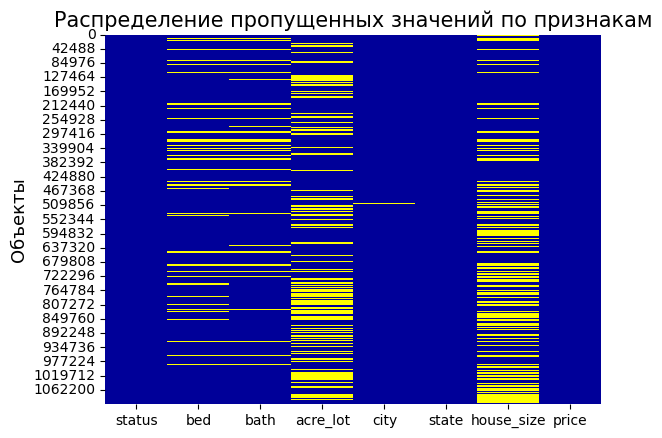

In [5]:
s = sns.heatmap(df.isnull(), cmap = sns.color_palette(['#000099', '#ffff00']), cbar = False)
s.set_ylabel('Объекты', fontsize = 13)
s.set_title('Распределение пропущенных значений по признакам', fontsize = 15)

plt.show()

In [6]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 616391


In [7]:
mis = {}

for feature in df.columns:
    mis[feature] = np.mean(df[feature].isnull()) * 100

for feature, val in sorted(mis.items(), key = lambda item: item[1], reverse = True):
    print(f'{feature} - {np.mean(df[feature].isnull()) * 100:.2f}%')

house_size - 33.57%
acre_lot - 30.77%
bed - 13.28%
bath - 11.28%
city - 0.01%
price - 0.01%
status - 0.00%
state - 0.00%


In [8]:
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
df[cat_features]= df[cat_features].apply(lambda col: col.fillna(col.value_counts().index[0]))

In [9]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 0


### Обработка выбросов

In [10]:
def show_boxplots(df, title = None):

    rows_cnt = int(np.ceil(len(df.columns) / 2))

    fig = plt.figure(layout = 'constrained', figsize = (10, 10))
    gs = GridSpec(rows_cnt, 2, figure = fig)

    for i, feature in enumerate(df.columns):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df.boxplot(column = feature, ax = ax)

    plt.suptitle(title, fontsize = 15)
    plt.show()

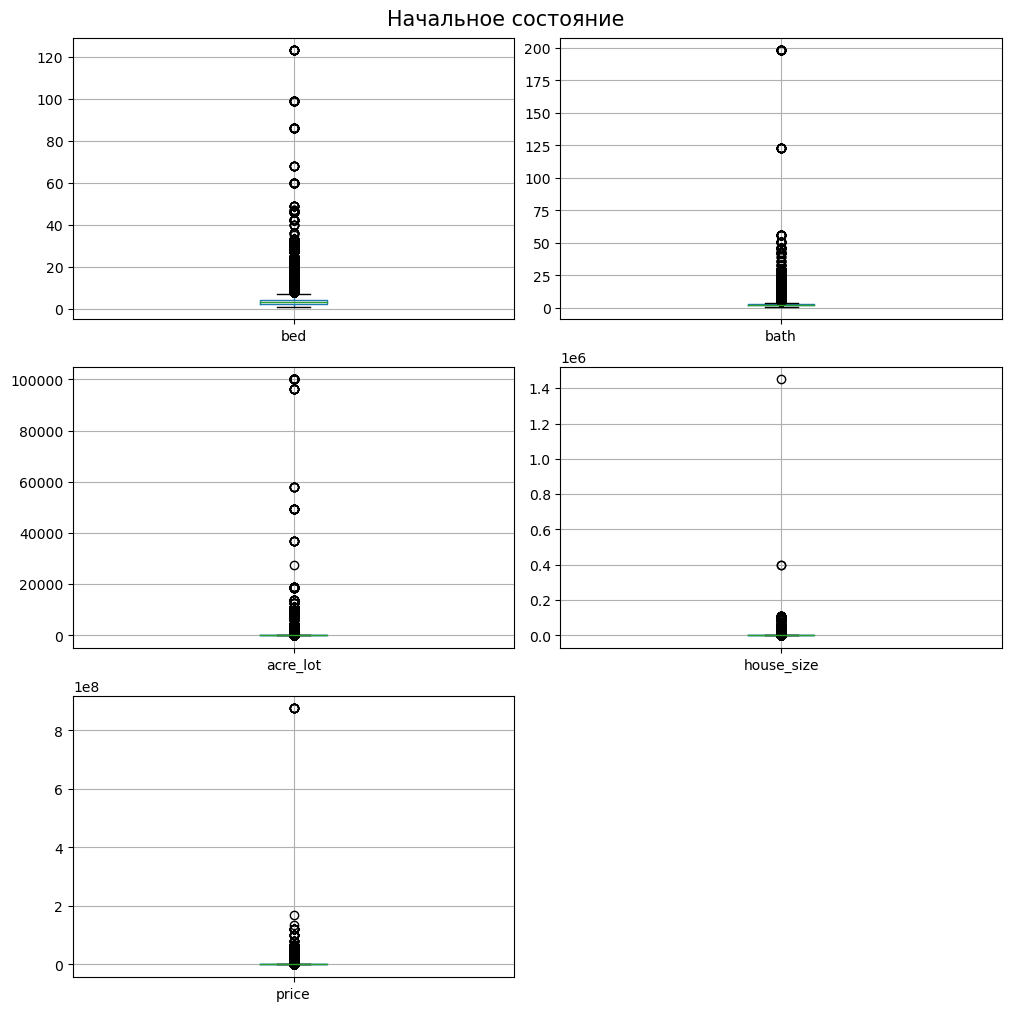

In [11]:
show_boxplots(df[numeric_features], title = 'Начальное состояние')

In [12]:
df.describe()

,bed,bath,acre_lot,house_size,price
count,1.104666e+06,1.104666e+06,1.104666e+06,1.104666e+06,1.104666e+06
mean,3.286994e+00,2.442391e+00,1.039693e+01,1.979548e+03,9.109493e+05
std,1.938814e+00,1.828853e+00,7.401477e+02,2.444088e+03,2.927197e+06
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00
25%,2.000000e+00,2.000000e+00,1.600000e-01,1.360000e+03,2.800000e+05
50%,3.000000e+00,2.000000e+00,2.600000e-01,1.647000e+03,4.999000e+05
75%,4.000000e+00,3.000000e+00,5.100000e-01,2.000000e+03,8.699000e+05
max,1.230000e+02,1.980000e+02,1.000000e+05,1.450112e+06,8.750000e+08


In [13]:
# Анализ с помощью межквантильного размаха
for feature in numeric_features:

    df_sorted = df[feature].sort_values()

    Q1 = df_sorted.quantile(q = .25)
    Q3 = df_sorted.quantile(q = .75)
    IQR = Q3 - Q1

    df = df[(df_sorted >= Q1 - 1.5 * IQR) & (df_sorted <= Q3 + 1.5 + IQR)] 

df = df.reset_index(drop = True)
df

,status,bed,bath,acre_lot,city,state,house_size,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,1647.0,65000.0
...,...,...,...,...,...,...,...,...
725564,for_sale,6.0,3.0,0.14,Wantagh,New York,1647.0,799999.0
725565,for_sale,4.0,3.0,0.14,East Meadow,New York,1597.0,599000.0
725566,for_sale,2.0,2.0,0.06,New York City,New York,862.0,765000.0
725567,for_sale,3.0,1.0,0.04,Long Beach,New York,1647.0,614999.0


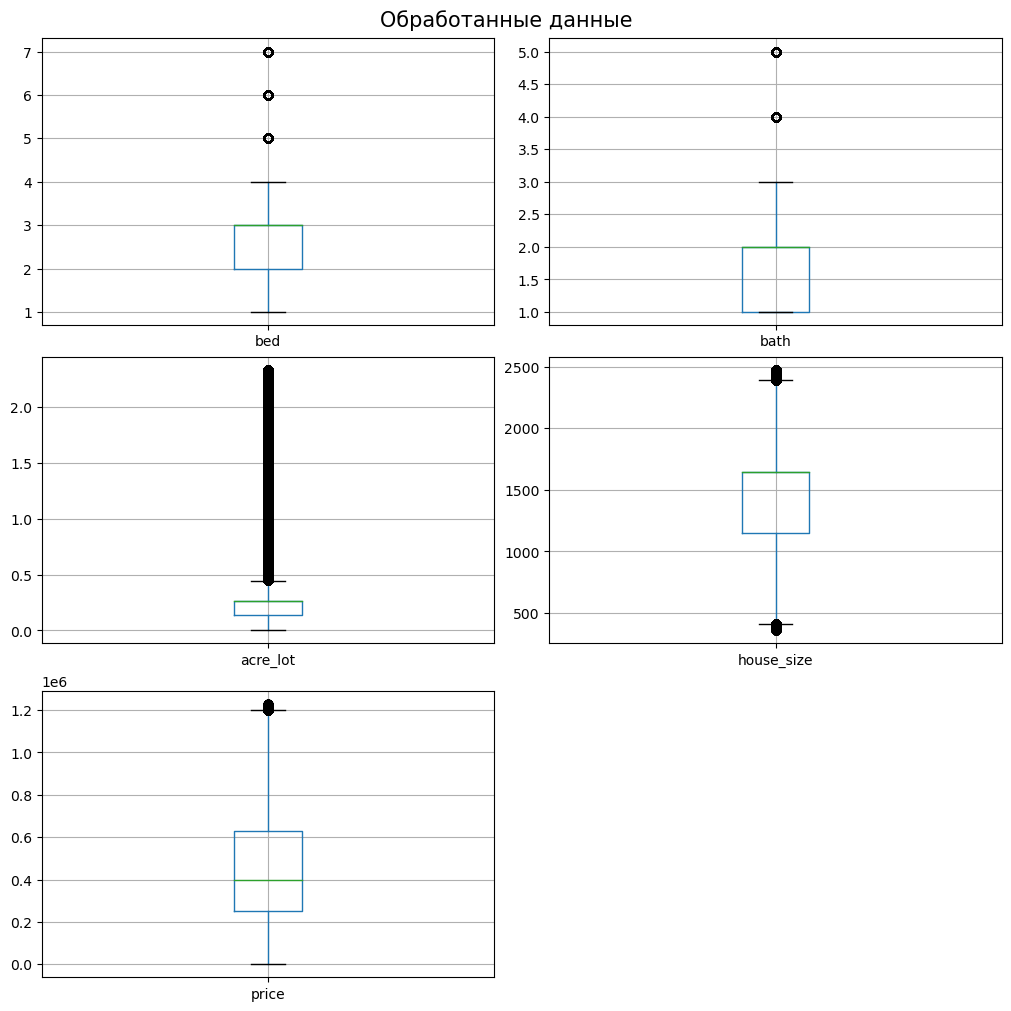

In [14]:
show_boxplots(df[numeric_features], title = 'Обработанные данные')

In [15]:
df.describe()

,bed,bath,acre_lot,house_size,price
count,725569.000000,725569.000000,725569.000000,725569.000000,7.255690e+05
mean,2.809778,1.940243,0.343378,1468.866421,4.564523e+05
std,1.159578,0.832476,0.394565,431.909876,2.697715e+05
min,1.000000,1.000000,0.000000,358.000000,0.000000e+00
25%,2.000000,1.000000,0.140000,1152.000000,2.499000e+05
50%,3.000000,2.000000,0.260000,1647.000000,4.000000e+05
75%,3.000000,2.000000,0.260000,1647.000000,6.299000e+05
max,7.000000,5.000000,2.330000,2473.000000,1.229000e+06


## Зависимости признаков

<AxesSubplot:>

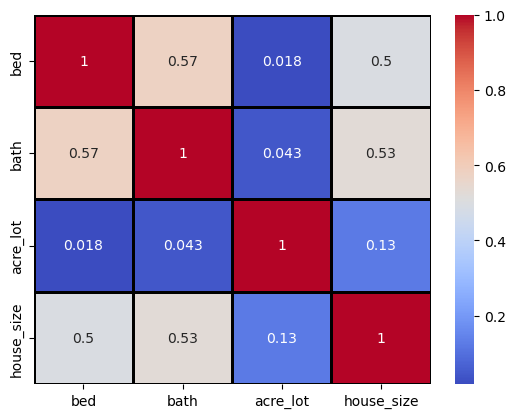

In [25]:
sns.heatmap(df[numeric_features].drop(['price'], axis = 1).corr(), 
            cmap = 'coolwarm', 
            linewidths = 2, 
            linecolor = 'black', 
            annot = True)

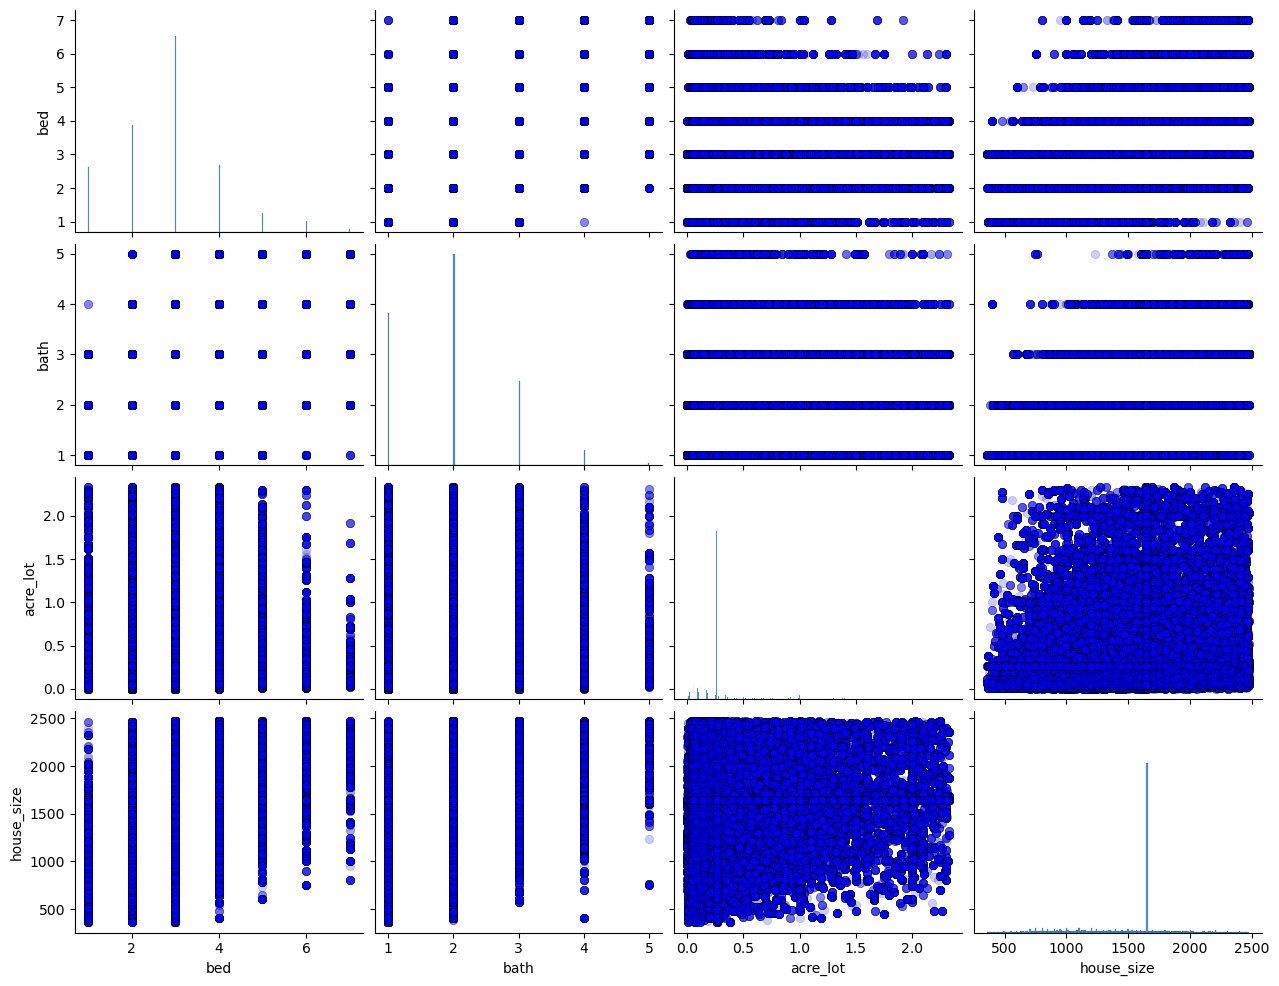

In [31]:
sns.pairplot(df[numeric_features].drop(['price'], axis = 1), 
             aspect = 1.3,
             plot_kws = {'edgecolor' : 'black', 
                         'alpha': .2,
                         'color' : 'b'})

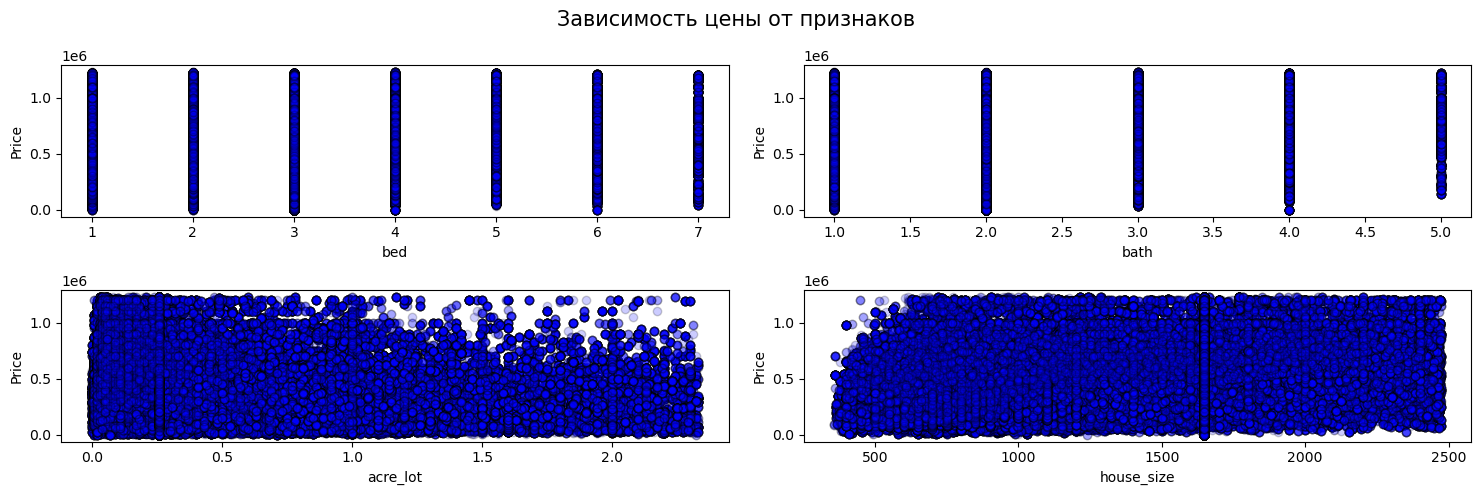

In [29]:
fig, axs = plt.subplots(2, 2, figsize = (15, 5))

for feature, ax in zip(df[numeric_features].drop(['price'], axis = 1).columns, axs.flatten()):
  
    ax.scatter(df[feature], df['price'], color = 'b', edgecolors = 'black', alpha = .2)

    ax.set_xlabel(feature)
    ax.set_ylabel('Price')

plt.suptitle('Зависимость цены от признаков', fontsize = 15)
plt.tight_layout()
plt.show()

# Задание 1, 2

In [32]:
def plot_regression(regressor, df, title = ''):
    _, axs = plt.subplots(2, 2, figsize = (15, 5))

    for feature, ax in zip(df.drop(['price'], axis = 1).columns, axs.flatten()):

        df_sort = df.sort_values(by = feature)
        X = np.reshape(df_sort.drop(['price'], axis = 1)[feature], (-1, 1))   
        y_true = df_sort['price']
        
        reg = regressor().fit(X, y_true)
        y_pred = reg.predict(X)
        
        ax.scatter(df[feature], df['price'], color = 'b', edgecolors = 'black', alpha = .2)
        ax.plot(X, y_pred, color = 'orange', linewidth = 3)
        
        ax.set_xlabel(feature)
        ax.set_ylabel('Price')

    plt.suptitle(reg.__class__.__name__ + '\n' + title, fontsize = 15)
    plt.tight_layout()
    plt.show()

In [33]:
def get_MSE(regressors, X, y_true):
    
    for regressor in regressors:
        y_pred = regressor.fit(X, y_true).predict(X)
        print(f'MSE({regressor.__class__.__name__}) = {mean_squared_error(y_true, y_pred):.2e}')

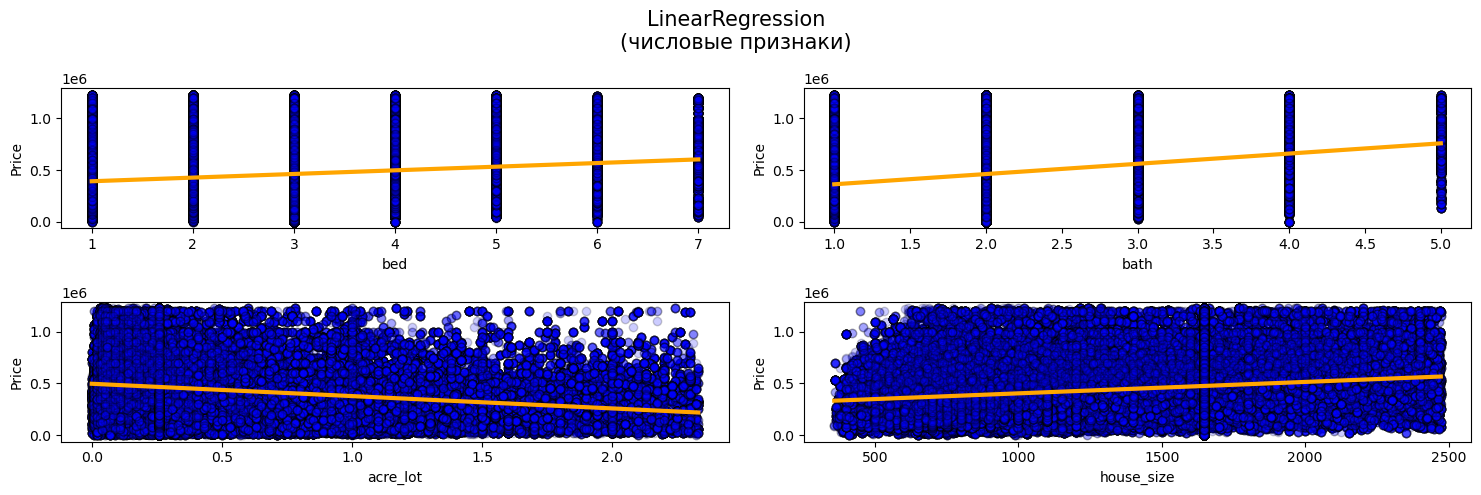

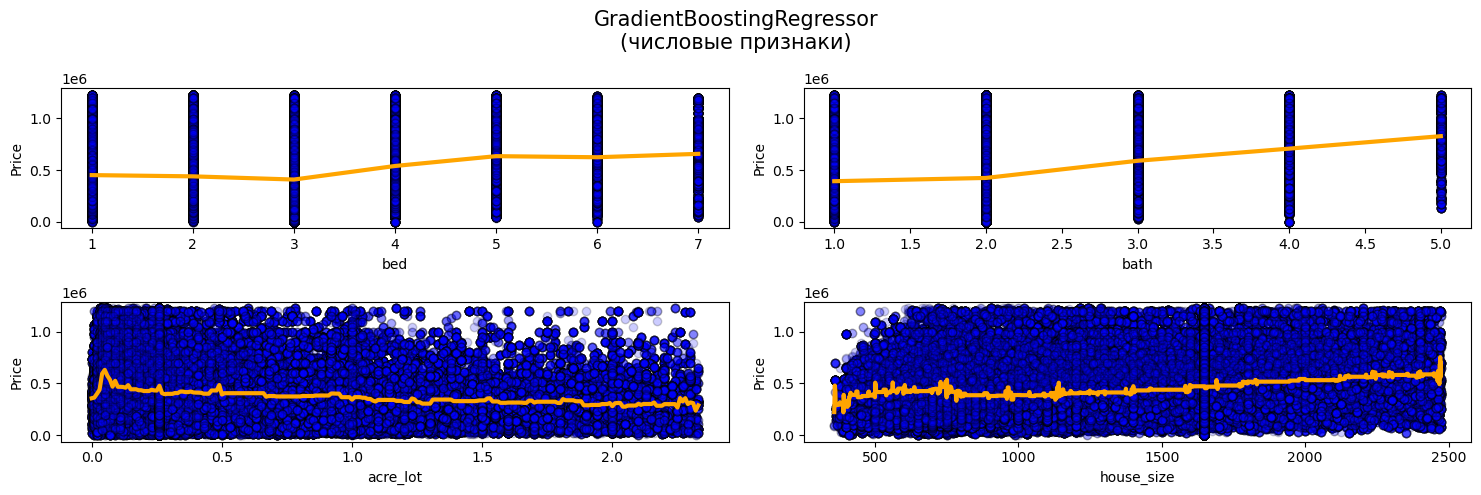

In [34]:
plot_regression(LinearRegression, df[numeric_features], title = '(числовые признаки)')
plot_regression(GradientBoostingRegressor, df[numeric_features], title = '(числовые признаки)')

In [74]:
X = df[numeric_features].drop(['price'], axis = 1)
y_true = df['price']

get_MSE([LinearRegression(), GradientBoostingRegressor()], X, y_true)

MSE(LinearRegression) = 6.15e+10
MSE(GradientBoostingRegressor) = 5.21e+10


# Задание 3

### OneHotEncoding

In [75]:
df_one_hot = pd.get_dummies(df[cat_features], dtype = int)
df_one_hot

,status_for_sale,status_ready_to_build,city_Abbot,city_Aberdeen,city_Abington,city_Absecon,city_Accord,city_Acton,city_Acushnet,city_Adams,...,state_Pennsylvania,state_Puerto Rico,state_Rhode Island,state_South Carolina,state_Tennessee,state_Vermont,state_Virgin Islands,state_Virginia,state_West Virginia,state_Wyoming
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593778,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593779,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593780,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
593781,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
get_MSE([LinearRegression(), GradientBoostingRegressor()], df_one_hot, df['price'])

MSE(LinearRegression) = 3.46e+10
MSE(GradientBoostingRegressor) = 4.69e+10


### TargetEncoding

In [77]:
df_target_enc = TargetEncoder(target_type = 'continuous').fit_transform(df[cat_features], df['price'])
df_target_enc

array([[434617.96428575,  93491.04207986, 176013.60216306],
       [434570.62597024,  93491.06616226, 176610.61268219],
       [434617.96428575,  97900.46290332, 176013.60216306],
       ...,
       [434223.68371877, 450090.08733753, 619573.20561464],
       [434617.96428575, 448262.69447995, 619861.34632531],
       [434617.96428575, 687400.24355339, 619861.34632531]])

In [78]:
get_MSE([LinearRegression(), GradientBoostingRegressor()], df_target_enc, df['price'])

MSE(LinearRegression) = 3.56e+10
MSE(GradientBoostingRegressor) = 3.50e+10


# Задание 4

In [54]:
df1 = df.drop(['price', 'state', 'city'], axis = 1)
df1['status'] = LabelEncoder().fit_transform(df1['status'])

df_scaled = pd.DataFrame(StandardScaler().fit_transform(df1), columns = df1.columns)
df_scaled

,status,bed,bath,acre_lot,house_size
0,-0.034887,0.164044,0.071783,-0.566139,-1.270790
1,-0.034887,1.026427,0.071783,-0.667517,0.134597
2,-0.034887,-0.698339,-1.129453,-0.490106,-1.669022
3,-0.034887,1.026427,0.071783,-0.616828,0.766673
4,-0.034887,2.751193,0.071783,-0.743550,0.412433
...,...,...,...,...,...
725564,-0.034887,2.751193,1.273018,-0.515451,0.412433
725565,-0.034887,1.026427,1.273018,-0.515451,0.296668
725566,-0.034887,-0.698339,0.071783,-0.718206,-1.405077
725567,-0.034887,0.164044,-1.129453,-0.768895,0.412433


In [93]:
pca = PCA(n_components = df_scaled.shape[1]).fit(df_scaled)

components = np.arange(pca.n_components_) + 1
eigenvalues = pca.explained_variance_ratio_

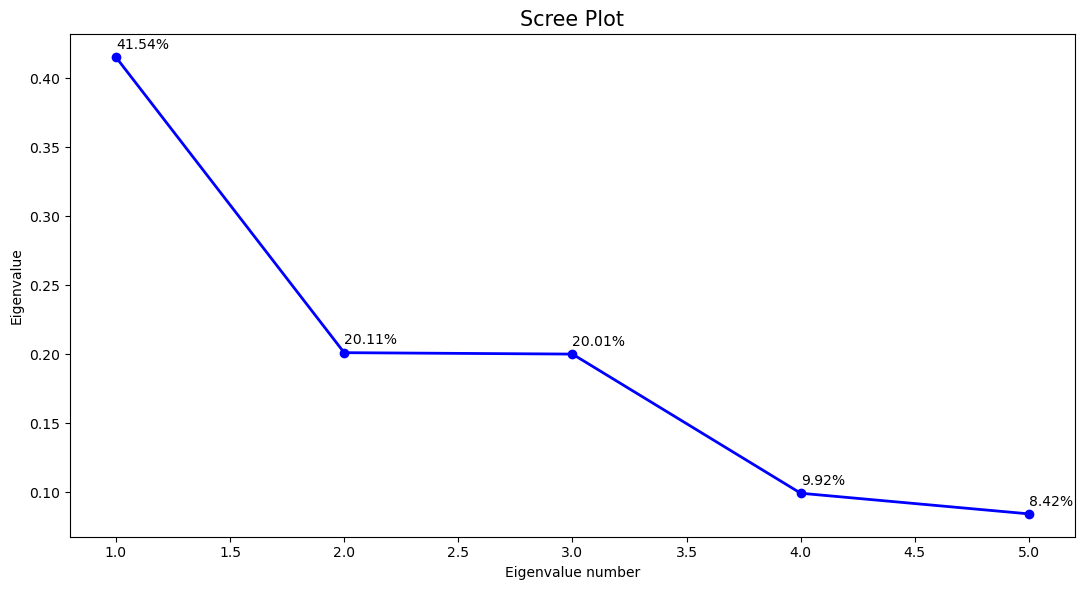

In [99]:
plt.figure(figsize = (11, 6))

plt.plot(components, eigenvalues, 'o-', linewidth = 2, color = 'b')

plt.title('Scree Plot', fontsize = 15)
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue')

for i, eigenvalue in enumerate(eigenvalues):
    plt.annotate(f'{eigenvalue * 100:.2f}%', (components[i], eigenvalue + 0.006))

plt.tight_layout()
plt.show()

In [154]:
df_transformed = pd.DataFrame(pca.transform(df_scaled), columns = [f'Factor {i + 1}: {eigenvalue * 100:.2f}%' 
                                                                   for i, eigenvalue in enumerate(eigenvalues)])

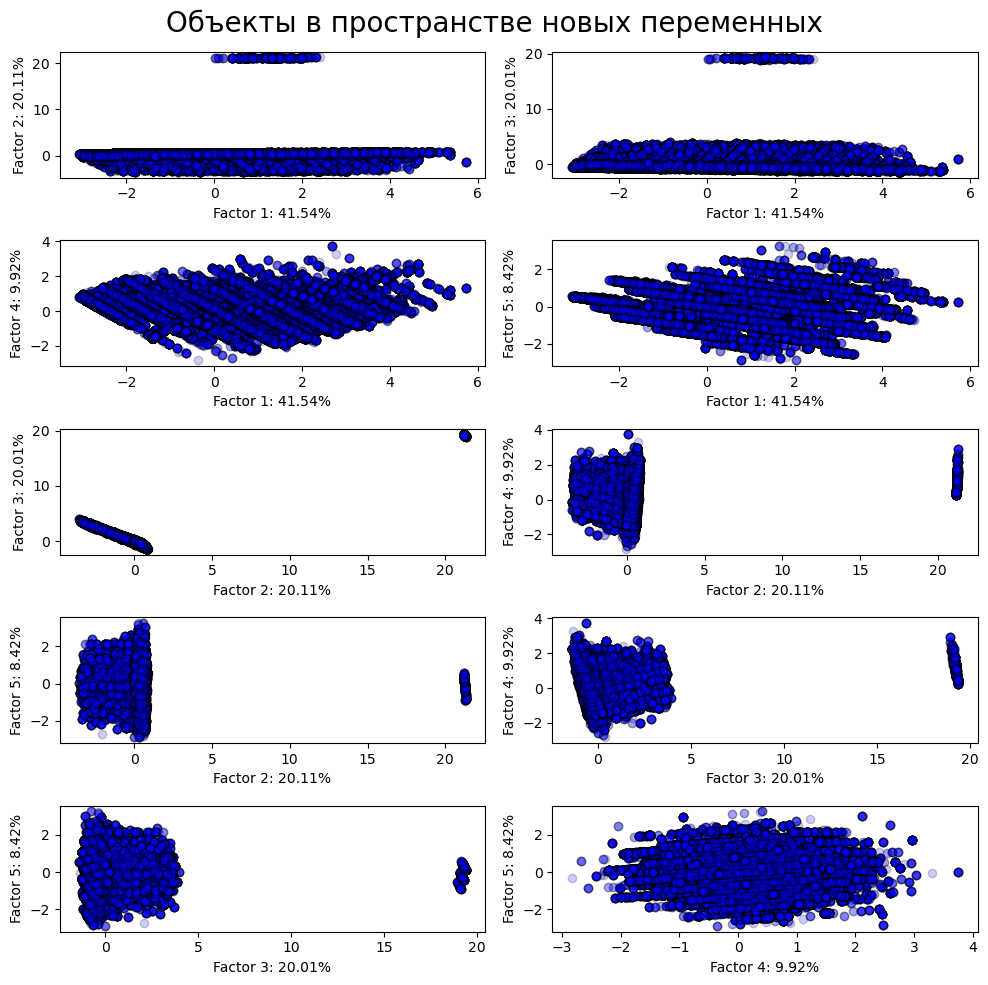

In [155]:
figure, axs = plt.subplots(5, 2, figsize = (10, 10))

for (col1, col2), ax in zip(combinations(df_transformed.columns, 2), axs.flatten()):

    ax.scatter(df_transformed[col1], df_transformed[col2], edgecolor = 'black', color = 'blue', alpha = .2)

    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

plt.suptitle('Объекты в пространстве новых переменных', fontsize = 20)

plt.tight_layout()
plt.show()